# Rethinking Statistics course in Stan - Week 6

Lecture 11: Maximum entropy & GLMs

- [Video](https://youtu.be/-4y4X8ELcEM)
- [Slides](https://speakerdeck.com/rmcelreath/l11-statistical-rethinking-winter-2019)

Lecture 12: God Spiked the Integers (binomial & Poisson GLMs)

- [Video](https://youtu.be/hRJtKCIDTwc)
- [Slides](https://speakerdeck.com/rmcelreath/l12-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week06.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week06_solutions.pdf) for the exercises of the week.

In [1]:
import pandas as pd
import numpy as np
from scipy.special import expit
from cmdstanpy import CmdStanModel
from plotnine import *

In [2]:
%load_ext watermark
%watermark -n -u -p pandas,numpy,cmdstanpy,plotnine,scipy

Last updated: Fri Dec 31 2021

pandas   : 1.3.4
numpy    : 1.21.4
cmdstanpy: 1.0.0
plotnine : 0.8.0
scipy    : 1.7.3



In [3]:
def waic(stan_fit):
    log_lik = stan_fit.stan_variable('log_lik')
    lppd = np.log(np.exp(log_lik).mean(axis=0)).sum()
    p_waic = np.var(log_lik, axis=0).sum()
    waic = -2*lppd + 2*p_waic
    return round(waic, 3)

In [4]:
def waic_point(stan_fit):
    log_lik = stan_fit.stan_variable('log_lik')
    lppd = np.log(np.exp(log_lik).mean(axis=0))
    p_waic = np.var(log_lik, axis=0)
    waic = -2*lppd + 2*p_waic
    return waic

## Exercise 1

> The data in data(`NWOGrants`) are outcomes for scientific funding applications for the Netherlands Organization for Scientific Research (NWO) from 2010–2012 (see [van der Lee and Ellemers](doi:10.1073/pnas.1510159112)). These data have a very similar structure to the `UCBAdmit` data discussed in Chapter 11 (_of the book!_).

> I want you to consider a similar question: What are the total and indirect causal effects of gender on grant awards? Consider a mediation path (a pipe) through discipline. Draw the corresponding DAG and then use one or more binomial GLMs to answer the question. What is your causal interpretation? If NWO's goal is to equalize rates of funding between the genders, what type of intervention would be most effective?

The implied DAG is:

<img src="./fig/w6_img1.png" width="30%">

where $G$ is gender, $D$ is discipline, and $A$ is award. The direct causal effect of gender is the path $G → A$. The total effect includes that path and the indirect path $G → D → A$. We can estimate the total causal influence (assuming this DAG is correct) with a model that conditions only on gender. I'll use a N(-1,1) prior for the intercepts, because we know from domain knowledge that less than half of applicants get awards.

Let's get the data.

In [5]:
d = pd.read_csv('./dat/NWOGrants.csv', header=0, sep=';')
d['gid'] = pd.factorize(d['gender'])[0]
d['apps'] = d['applications']
d['disc'] = pd.factorize(d['discipline'])[0]
d.tail(3)

,discipline,gender,applications,awards,gid,apps,disc
15,Social sciences,f,409,47,1,409,7
16,Medical sciences,m,245,46,0,245,8
17,Medical sciences,f,260,29,1,260,8


Total effect of gender on awards:

In [6]:
ngid = d.gid.unique().size

model = '''

data {
    int n; 
    int gid[n];
    int apps[n];
    int awards[n];
}

parameters {
    real a[%s];
}

model {
    // prior
    a ~ normal(-1,1);
    // likelihood
    for (i in 1:n) {
        awards[i] ~ binomial_logit(apps[i], a[gid[i]]);
    } 
}

''' % (ngid)

stan_file = './stn/week06_01a.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
    
model_1a = CmdStanModel(stan_file=stan_file)
model_1a.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week06_01a.stan to exe file /home/jovyan/work/statret/stn/week06_01a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week06_01a
INFO:cmdstanpy:found newer exe file, not recompiling


In [7]:
%%time
data = d[['gid', 'apps', 'awards']].copy()
data.gid = data.gid + 1
data = data.to_dict(orient='list')
data['n'] = len(data['awards'])
fit_1a = model_1a.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 185 ms, sys: 108 ms, total: 293 ms
Wall time: 291 ms


In [8]:
fit_1a.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1300.0,0.0230,1.000,-1300.0,-1300.0,-1300.0,1800.0,17000.0,1.0
a[1],-1.5,0.0011,0.064,-1.6,-1.5,-1.4,3474.0,32775.0,1.0
a[2],-1.7,0.0013,0.081,-1.9,-1.7,-1.6,3737.0,35252.0,1.0


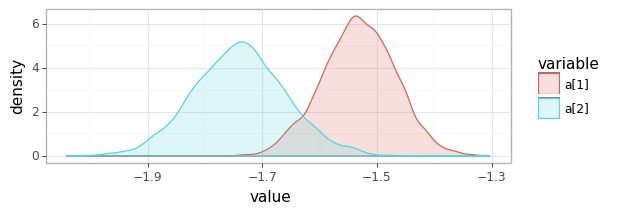

<ggplot: (8738518433512)>

In [9]:
atts = ['a']
df = fit_1a.draws_pd(vars=atts)
im = pd.melt(df, value_vars=df.columns)

(
    ggplot(im)
    + aes(x='value', color='variable', fill='variable')
    + geom_density(alpha=0.2)
    + theme_light()
    + theme(figure_size=(6,2))
)

Gender 1 here is male and 2 is female. So males have higher rates of award, on average. How big is the difference? Let's look at the contrast on absolute (penguin) scale:

In [10]:
posterior = fit_1a.draws_pd(vars='a')
probs = expit(posterior)
prob_m = probs['a[1]'].mean()
prob_f = probs['a[2]'].mean()
print(f'prob_m = {prob_m:.2f}, logit_f = {prob_f:.2f}')

prob_m = 0.18, logit_f = 0.15


We can see that that difference is just the average in acceptance rate (by gender) which makes total sense.

In [11]:
rate_by_gid = d.groupby('gid')[['awards','apps']].sum().reset_index()
rate_by_gid['rate']=rate_by_gid.awards/rate_by_gid.apps
rate_by_gid.round(2)

,gid,awards,apps,rate
0,0,290,1635,0.18
1,1,177,1188,0.15


So a small 3% difference on average. Still, with such low funding rates (in some disciplines), 3% is a big advantage. Now for the direct influence of gender, we condition on discipline as well:

In [12]:
ngid = d.gid.unique().size
ndsc = d.disc.unique().size

model = '''

data {
    int n;
    int gid[n];
    int disc[n];
    int apps[n];
    int awards[n];
}

parameters {
    real a[%s];
    real d[%s];
}

model {
    // prior
    a ~ normal(-1,1);
    d ~ normal(0,1);
    //likelihood
    vector[n] alpha;
    for (i in 1:n) {
        alpha[i] = a[gid[i]] + d[disc[i]];
    }
    awards ~ binomial_logit(apps, alpha);
}

''' % (ngid, ndsc)

stan_file = './stn/week06_01b.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
    
model_1b = CmdStanModel(stan_file=stan_file)
model_1b.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week06_01b.stan to exe file /home/jovyan/work/statret/stn/week06_01b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week06_01b
INFO:cmdstanpy:found newer exe file, not recompiling


In [13]:
%%time
data = d[['gid', 'apps', 'awards', 'disc']].copy()
data.gid = data.gid + 1
data.disc = data.disc + 1
data = data.to_dict(orient='list')
data['n'] = len(data['awards'])
fit_1b = model_1b.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 204 ms, sys: 80 ms, total: 284 ms
Wall time: 388 ms


In [14]:
fit_1b.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-1300.0000,0.061,2.40,-1300.00,-1300.000,-1300.000,1500.0,4500.0,1.0
a[1],-1.3000,0.013,0.30,-1.80,-1.300,-0.840,479.0,1425.0,1.0
a[2],-1.5000,0.014,0.30,-2.00,-1.500,-0.990,492.0,1463.0,1.0
d[1],0.3300,0.013,0.35,-0.25,0.330,0.890,660.0,1964.0,1.0
d[2],-0.0190,0.014,0.34,-0.55,-0.020,0.520,599.0,1783.0,1.0
d[3],0.2900,0.014,0.38,-0.33,0.280,0.910,750.0,2232.0,1.0
d[4],-0.2400,0.014,0.32,-0.75,-0.240,0.290,539.0,1603.0,1.0
d[5],-0.2100,0.014,0.33,-0.75,-0.200,0.340,542.0,1612.0,1.0
d[6],-0.2700,0.014,0.35,-0.83,-0.270,0.300,660.0,1963.0,1.0


Now, we can compute the gender difference again. On the probability scale:

In [15]:
posterior = fit_1b.draws_pd(vars='a')
probs = expit(posterior)
prob_m = probs['a[1]'].mean()
prob_f = probs['a[2]'].mean()
print(f'prob_m = {prob_m:.2f}, logit_f = {prob_f:.2f}')

prob_m = 0.21, logit_f = 0.19


Still an advantage for the males, but reduced and overlapping zero a bit. To see this difference on the absolute scale, we need to account for the base rates in each discipline as well. There are also several disciplines that reverse the advantage. If there is a direct influence of gender here, it is small, much smaller than before we accounted for discipline. Why? Because again the disciplines have different funding rates and women apply more to the disciplines with lower funding rates. But it would be hasty, I think, to conclude there are no other influences. There are after all lots of unmeasured confounds...

## Exercise 2

> Suppose that the NWO Grants sample has an unobserved confound that influences both choice of discipline and the probability of an award. One example of such a confound could be the career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the grants. In other disciplines, scholars from all career stages compete. As a result, career stage influences discipline as well as the probability of being awarded a grant.

> Add these influences to your DAG from Problem 1. What happens now when you condition on discipline? Does it provide an un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your answer with the back-door criterion. Hint: This is structurally a lot like the grandparents-parents-children-neighborhoods example from a previous week.

> If you have trouble thinking this though, try simulating fake data, assuming your DAG is true. Then analyze it using the model from Problem 1. What do you conclude? Is it possible for gender to have a real direct causal influence but for a regression conditioning on both gender and discipline to suggest zero influence?

The implied DAG is:

<img src="./fig/w6_img2.png" width="30%">

where `S` is stage of career (unobserved), `D`is discpline, `A`is award and `G` is gender. This DAG has the same structure as the grandparents-parents-children-neighborhoods example from earlier in the course. When we condition on discipline `D` it opens a back-door path through S to A. It is not possible here to get an unconfounded estimate of gender on awards. This code simulates 1000 applicants. There are 2 genders (`G` 0/1), 2 stages of career (`S` 0/1), and 2 disciplines (`D` 0/1). Discipline 1 is chosen more by gender 1 and career stage 1. So that could mean more by males and later stage of career. Then awards `A` have a consistent bias towards gender 1, and discipline 1 has a higher award rate, and stage 1 also a higher award rate. If we analyze these data:

In [16]:
N = 1000
G = np.random.binomial(n=1, p=0.5, size=N)
S = np.random.binomial(n=1, p=0.5, size=N)
D = np.random.binomial(n=1, p=expit((G+S).astype('float')), size=N)
A = np.random.binomial(n=1, p=expit((D+0.25*G+2*S-2).astype('float')), size=N)
d1 = pd.DataFrame(data={'gender': G, 'stage':S, 'disc': D, 'award':A})
d1.head()

,gender,stage,disc,award
0,0,0,0,0
1,1,0,1,0
2,1,1,1,0
3,1,0,0,0
4,1,0,1,0


In [17]:
model = '''

data {
    int n;
    int gender[n];
    int disc[n];
    int award[n];
}

parameters {
    real a;
    real g;
    real d;
}

model {
    // prior
    a ~ normal(0,1);
    g ~ normal(0,1);
    d ~ normal(0,1);
    // likelihood
    vector[n] alpha;
    for (i in 1:n) {alpha[i] = a + g*gender[i] + d*disc[i];}
    award ~ bernoulli_logit(alpha);
}

'''

stan_file = './stn/week06_02.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
    
model = CmdStanModel(stan_file=stan_file)
model.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week06_02.stan to exe file /home/jovyan/work/statret/stn/week06_02
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week06_02
INFO:cmdstanpy:found newer exe file, not recompiling


In [18]:
%%time
data = d1[['gender', 'disc', 'award']].copy()
data = data.to_dict(orient='list')
data['n'] = len(data['award'])
fit = model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 274 ms, sys: 105 ms, total: 379 ms
Wall time: 2.38 s


In [19]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-660.00,0.0300,1.20,-660.000,-660.00,-660.00,1600.0,400.0,1.0
a,-1.10,0.0033,0.14,-1.300,-1.10,-0.84,1800.0,450.0,1.0
g,0.31,0.0028,0.13,0.093,0.31,0.52,2200.0,540.0,1.0
d,0.94,0.0036,0.16,0.690,0.95,1.20,1800.0,450.0,1.0


The parameter `g` is the advantage of gender 1. It is smaller than the true advantage and the estimate straddles zero quite a lot, even with 1000 applicants. It is also possible to have no gender influence and infer it by accident. Try these settings:

In [20]:
N = 1000
G = np.random.binomial(n=1, p=0.5, size=N)
S = np.random.binomial(n=1, p=0.5, size=N)
D = np.random.binomial(n=1, p=expit((G+S).astype('float')), size=N)
A = np.random.binomial(n=1, p=expit((D+0*G+S-2).astype('float')), size=N)
d2 = pd.DataFrame(data={'gender': G, 'stage':S, 'disc': D, 'award':A})
d2.head()

,gender,stage,disc,award
0,1,0,1,0
1,1,1,1,0
2,0,1,1,1
3,0,0,1,0
4,0,1,1,1


In [21]:
%%time
data = d2[['gender', 'disc', 'award']].copy()
data = data.to_dict(orient='list')
data['n'] = len(data['award'])
fit = model.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



CPU times: user 271 ms, sys: 87.1 ms, total: 358 ms
Wall time: 2.4 s


In [22]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-600.00,0.0300,1.20,-610.00,-600.000,-600.00,1600.0,390.0,1.0
a,-1.60,0.0040,0.16,-1.80,-1.600,-1.30,1600.0,370.0,1.0
g,-0.08,0.0030,0.14,-0.31,-0.081,0.15,2200.0,510.0,1.0
d,1.10,0.0045,0.18,0.84,1.100,1.40,1500.0,350.0,1.0


Now it looks like gender 1 has a consistent advantage, but in fact there is no advantage in the simulation.

## Exercise 3

> The data in data(`Primates301`) were first introduced at the end of Chapter 7. In this problem, you will consider how brain size is associated with social learning. There are three parts.

> First, model the number of observations of `social_learning` for each species as a function of the log `brain` size. Use a Poisson distribution for the `social_learning` outcome variable. Interpret the resulting posterior.

> Second, some species are studied much more than others. So the number of reported instances of `social_learning` could be a product of research effort. Use the `research_effort` variable, specifically its logarithm, as an additional predictor variable. Interpret the coefficient for log `research_effort`. Does this model disagree with the previous one?

> Third, draw a DAG to represent how you think the variables `social_learning`, `brain`, and `research_effort` interact. Justify the DAG with the measured associations in the two models above (and any other models you used).

In [23]:
d = pd.read_csv('./dat/Primates301.csv', header=0, sep=';')
d.dropna(subset=['social_learning', 'research_effort', 'brain'], inplace=True)
log_brain = np.log(d['brain'].values)
d['log_brain'] = (log_brain - np.mean(log_brain)/np.std(log_brain))
d['log_effort'] = np.log(d['research_effort'].values)
d['soc_learn'] = d['social_learning']
d.soc_learn = pd.to_numeric(d.soc_learn, downcast='integer')
d[['log_brain', 'log_effort', 'soc_learn']].tail(3)

,log_brain,log_effort,soc_learn
296,1.650598,1.609438,0
298,1.125291,0.693147,0
300,0.479154,4.043051,0


Now we first want a model with social learning as the outcome and brain size as a predictor. For this Poisson GLM, I'm going to use a N(0,1) prior on the intercept, since we know the counts should be small.

In [24]:
model = '''

data {
    int n;
    vector[n] log_brain;
    int soc_learn[n];
}

parameters {
    real a;
    real bb;
}

transformed parameters {
    vector[n] mu;
    mu = exp(a + bb*log_brain);
}

model {
    // prior
    a ~ normal(0,1);
    bb ~ normal(0, 0.5);
    // likelihood
    soc_learn ~ poisson(mu);
}

generated quantities {
    vector[n] log_lik;
    for (i in 1:n) {
        log_lik[i] = poisson_lpmf(soc_learn[i] | mu[i]);
    }
}

'''

stan_file = './stn/week06_03a.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
    
model_3a = CmdStanModel(stan_file=stan_file)
model_3a.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week06_03a.stan to exe file /home/jovyan/work/statret/stn/week06_03a
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week06_03a
INFO:cmdstanpy:found newer exe file, not recompiling


In [25]:
data = d[['log_brain', 'soc_learn']].to_dict(orient='list')
data['n'] = len(data['soc_learn'])
fit_3a = model_3a.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [26]:
fit_3a.summary().loc[['a', 'bb']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
a,-2.6,0.0052,0.150,-2.9,-2.6,-2.4,890.0,800.0,1.0
bb,2.3,0.0020,0.061,2.2,2.3,2.4,890.0,800.0,1.0


Brain size seems to be strongly associated with social learning observations. Let's try the research effort variable now:

In [27]:
model = '''

data {
    int n;
    vector[n] log_brain;
    vector[n] log_effort;
    int soc_learn[n];
}

parameters {
    real a;
    real bb;
    real be;
}

transformed parameters {
    vector[n] mu;
    mu = exp(a + bb*log_brain + be*log_effort);
}

model {
    // prior
    a ~ normal(0,1);
    bb ~ normal(0, 0.5);
    be ~ normal(0, 0.5);
    // likelihood
    soc_learn ~ poisson(mu);
}

generated quantities {
    vector[n] log_lik;
    for (i in 1:n) {
        log_lik[i] = poisson_lpmf(soc_learn[i] | mu[i]);
    }
}

'''

stan_file = './stn/week06_03b.stan'
with open(stan_file, 'w') as f:
    print(model, file=f)
    
model_3b = CmdStanModel(stan_file=stan_file)
model_3b.compile()

INFO:cmdstanpy:compiling stan file /home/jovyan/work/statret/stn/week06_03b.stan to exe file /home/jovyan/work/statret/stn/week06_03b
INFO:cmdstanpy:compiled model executable: /home/jovyan/work/statret/stn/week06_03b
INFO:cmdstanpy:found newer exe file, not recompiling


In [28]:
data = d[['log_brain', 'log_effort', 'soc_learn']].to_dict(orient='list')
data['n'] = len(data['soc_learn'])
fit_3b = model_3b.sample(data=data, chains=4)

INFO:cmdstanpy:CmdStan start procesing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [29]:
fit_3b.summary().loc[['a', 'bb', 'be']]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
a,-6.20,0.0094,0.290,-6.70,-6.20,-5.70,960.0,440.0,1.0
bb,0.37,0.0019,0.069,0.26,0.37,0.49,1300.0,610.0,1.0
be,1.50,0.0022,0.066,1.40,1.50,1.60,910.0,420.0,1.0


Brain size `bb` is still positively associated, but much less. Research effort be is strongly associated. To see how these models disagree, let's use WAIC to see which cases each predicts well.

In [30]:
d['waic_diff'] = waic_point(fit_3a) - waic_point(fit_3b)

In [31]:
sc = {
    '3a' : waic(fit_3a).sum(),
    '3b' : waic(fit_3b).sum()
}
scores = pd.DataFrame(sc.items(), columns=['model','waic'])
scores.sort_values(by='waic')

,model,waic
1,3b,568.756
0,3a,1409.104


This is a good example of how the nature of measurement influences inference. Species on the right of the vertical line fit better for model `model_3b`, the model with research effort. These are mostly species that are studied a lot, like chimpanzees (Pan) and macaques (Macaca). The genus Pan especially has been a focus on social learning research, and its counts are inflated by this. There are likely a lot of false zeros in these data, species that are not studied often enough to get a good idea of their learning tendencies. Meanwhile every time a chimpanzee sneezes, someone writes a social learning paper.

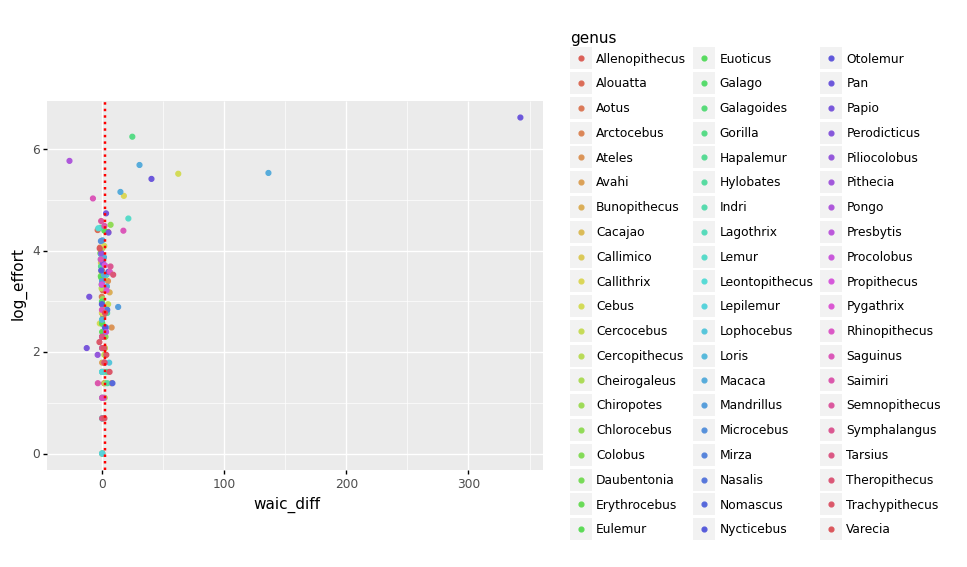

<ggplot: (8738506268221)>

In [32]:
(
    ggplot(d)
    + aes(x='waic_diff', y='log_effort', color='genus')
    + geom_point()
    + geom_vline(xintercept=2, linetype='dotted', color='red', size=1)
)

Okay, finally I asked for a DAG. This is my guess:

<img src="./fig/w6_img3.png" width="30%">

`B` is brain size, `E` is research effort, and `S` is social learning. Research effort doesn't actually influence social learning, but it does influence the value of the variable. The model results above are consistent with this DAG in the sense that including `E` reduced the association with `B`, which we would expect when we close the indirect path through `E`. If researchers choose to look for social learning in species with large brains, this leads to an exaggerated estimate of the association between brains and social learning.